In [7]:
#%pip install micrograd --quiet

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [10]:
np.random.seed(1337)
random.seed(1337)

### Make up a dataset

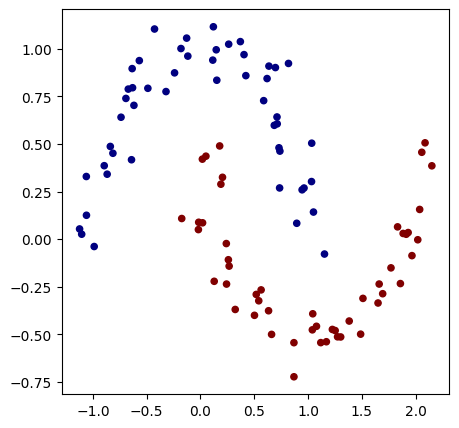

In [12]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Initialize a model 

In [13]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


#### Loss function 

In [14]:
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9219220440708354, grad=0) 0.5


#### Optimization

In [16]:
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 5 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.19804839220213744, accuracy 94.0%
step 5 loss 0.24672248029881824, accuracy 90.0%
step 10 loss 0.11462603871211018, accuracy 97.0%
step 15 loss 0.16748079173634225, accuracy 93.0%
step 20 loss 0.061716686945202125, accuracy 99.0%
step 25 loss 0.06513144508540747, accuracy 98.0%
step 30 loss 0.04222444942627202, accuracy 99.0%
step 35 loss 0.04889118476767827, accuracy 99.0%
step 40 loss 0.024106844141993013, accuracy 99.0%
step 45 loss 0.02942947332012279, accuracy 100.0%
step 50 loss 0.024905708104035043, accuracy 99.0%
step 55 loss 0.019293939608525292, accuracy 100.0%
step 60 loss 0.01778576221766042, accuracy 100.0%
step 65 loss 0.015836073894976793, accuracy 100.0%
step 70 loss 0.014353628187808278, accuracy 100.0%
step 75 loss 0.014283006307858672, accuracy 100.0%
step 80 loss 0.013501075237247298, accuracy 100.0%
step 85 loss 0.013070661438117028, accuracy 100.0%
step 90 loss 0.012660005324128556, accuracy 100.0%
step 95 loss 0.01286610384023592, accuracy 100.0%


#### Visualize decision boundary


(-1.7222875713140986, 2.027712428685901)

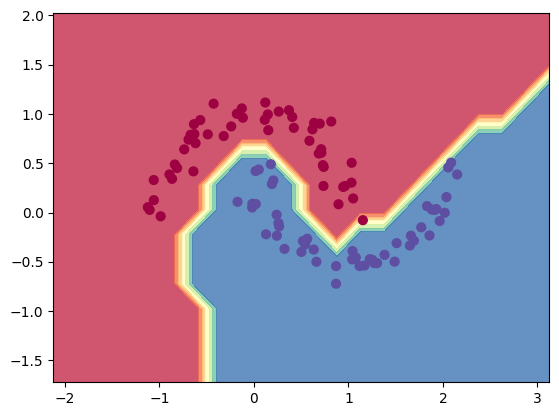

In [17]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())